# Імпорт бібліотек

In [1]:
!pip install shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import shap

pd.set_option('display.max.columns', 100)
pd.set_option('float_format', '{:.2f}'.format)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/MyDrive/ML_homework/Mid-term проєкт/bank-additional-full.csv.zip'

df = pd.read_csv(file_path, sep=';')

# Препроцесинг даних

Очищення та видалення змінних

Видалимо duration, бо ми не знаємо тривалість дзвінка до того, як він відбувся та default, так як ця колонка має 21% значень 'unknown' і лише 3 значення 'yes'

In [4]:
df_processed = df.copy()

In [5]:
df_processed = df_processed.drop(columns=['duration', 'default'])

Обробка "unknown"

Для стовпців job, marital, education, housing та loan, де 'unknown' зустрічається рідко можна заповнити їх найбільш частим значенням цього стовпця

In [6]:
cols_with_unknown = ['job', 'marital', 'education', 'housing', 'loan']

In [7]:
for col in cols_with_unknown:
    mode_val = df_processed[col].mode()[0]
    df_processed[col] = df_processed[col].replace('unknown', mode_val)
    print(f"'{col}': 'unknown' замінено на '{mode_val}'")

'job': 'unknown' замінено на 'admin.'
'marital': 'unknown' замінено на 'married'
'education': 'unknown' замінено на 'university.degree'
'housing': 'unknown' замінено на 'yes'
'loan': 'unknown' замінено на 'no'


Групування та створення нових ознак

1.   З EDA ми бачили, що найвища конверсія у молоді <30 та пенсіонерів 60+.Можна створити нову категоріальну ознаку age_group '<30', '30-59', '60+'
2.   Можна згрупувати рівні освіти, об'єднавши basic.4y, basic.6y та basic.9y в одну категорію Basic
3. Значення 999 означає, що "клієнта не контактували". Можна створити нову бінарну ознаку is_prev_contacted (1, якщо pdays != 999, і 0, якщо pdays == 999)


In [8]:
bins = [0, 29, 59, 100]
labels = ['young', 'mid_age', 'senior']
df_processed['age_group'] = pd.cut(df_processed['age'], bins=bins, labels=labels, right=True)

In [9]:
basic_levels = ['basic.4y', 'basic.6y', 'basic.9y']
df_processed['education_group'] = df_processed['education'].replace(basic_levels, 'Basic')

In [10]:
df_processed['is_prev_contacted'] = (df_processed['pdays'] != 999).astype(int)

In [11]:
df_processed = df_processed.drop(['age', 'education', 'pdays'], axis=1)

In [12]:
df_processed['y'] = df_processed['y'].apply(lambda x: 1 if x == 'yes' else 0)

In [13]:
X = df_processed.drop('y', axis=1)

y = df_processed['y']

Для викидів в колонках campaign і previous застосуємо логарифмування. Це "стисне" великі значення і зробить розподіл більш нормальним

In [14]:
log_transform_cols = ['campaign', 'previous']

In [15]:
numeric_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'is_prev_contacted']

In [16]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [17]:
print(f"\nЧислові (для Log): {log_transform_cols}")
print(f"Числові (для Scale): {numeric_cols}")
print(f"Категоріальні (для OHE): {categorical_cols}")


Числові (для Log): ['campaign', 'previous']
Числові (для Scale): ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'is_prev_contacted']
Категоріальні (для OHE): ['job', 'marital', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age_group', 'education_group']


# Розбиття даних та навчання базових моделей

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

In [19]:
log_transformer = FunctionTransformer(np.log1p, validate=True)

In [20]:
log_pipeline = Pipeline(steps=[
    ('log', log_transformer),
    ('scale', StandardScaler())
])

In [21]:
numeric_pipeline = Pipeline(steps=[
    ('scale', StandardScaler())
])

In [22]:
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ('log_transform', log_pipeline, log_transform_cols),
        ('numeric_transform', numeric_pipeline, numeric_cols),
        ('categorical_transform', categorical_pipeline, categorical_cols)
    ],
    remainder='passthrough'
)

In [24]:
X_train_processed = preprocessor.fit_transform(X_train)

X_test_processed = preprocessor.transform(X_test)

In [25]:
ohe_feature_names = preprocessor.named_transformers_['categorical_transform'].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = log_transform_cols + numeric_cols + list(ohe_feature_names)

X_train_df = pd.DataFrame(X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed, columns=all_feature_names)
X_test_df = pd.DataFrame(X_test_processed.toarray() if hasattr(X_test_processed, 'toarray') else X_test_processed, columns=all_feature_names)

In [26]:
models = {
    "Logistic Regression": LogisticRegression(random_state=17, max_iter=1000),
    "kNN": KNeighborsClassifier(n_neighbors=30),
    "Decision Tree": DecisionTreeClassifier(random_state=17, max_depth=10),
    "XGBoost": XGBClassifier(random_state=17)
}

--- Logistic Regression ---
Train AUC: 0.7939
Test AUC:  0.7937
--------------------
--- kNN ---
Train AUC: 0.8513
Test AUC:  0.7744
--------------------
--- Decision Tree ---
Train AUC: 0.8385
Test AUC:  0.7540
--------------------
--- XGBoost ---
Train AUC: 0.8908
Test AUC:  0.7863
--------------------


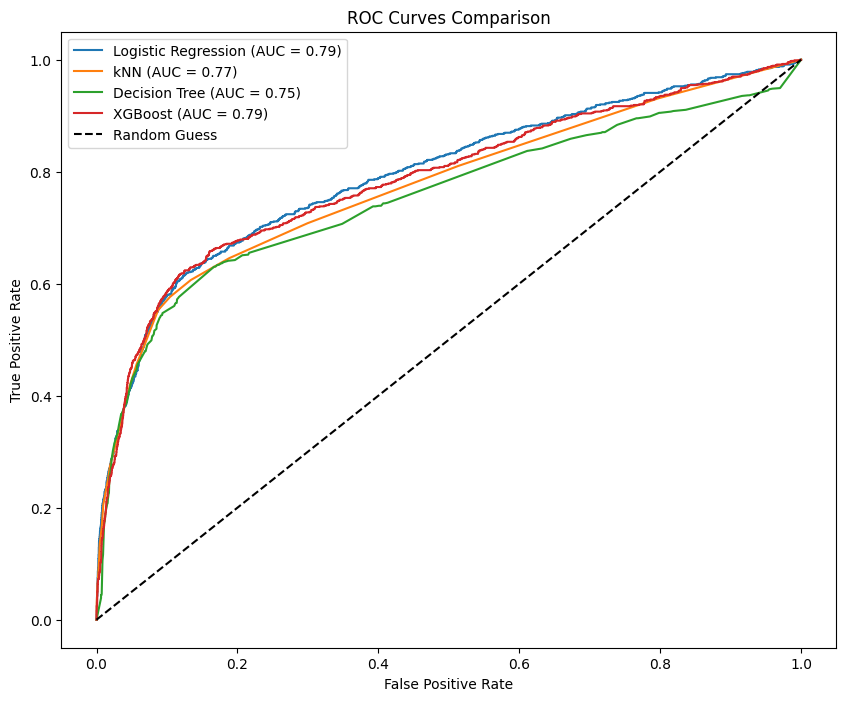

In [27]:
results = []
table_data = []

plt.figure(figsize=(10, 8))

for name, model in models.items():

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])

    clf.fit(X_train, y_train)

    y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
    y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    test_auc = roc_auc_score(y_test, y_test_pred_proba)

    table_data.append({
        'Модель': name,
        'Гіперпараметри': str(model),
        'Train AUC-ROC': train_auc,
        'Test AUC-ROC': test_auc
    })

    print(f"--- {name} ---")
    print(f"Train AUC: {train_auc:.4f}")
    print(f"Test AUC:  {test_auc:.4f}")
    print("-" * 20)

    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {test_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

In [28]:
results_df = pd.DataFrame(table_data)

results_df = results_df.sort_values(by='Test AUC-ROC', ascending=False)

pd.set_option('display.max_colwidth', None)

comments_dict = {
    "Logistic Regression": "Хороша базова модель, найбільш стабільна і без перенавчання.",
    "kNN": "Помітне падіння якості на тесті і ця модель повільніша",
    "Decision Tree": "Помітне перенавчання (Train значно кращий за Test)",
    "XGBoost": "Також помітне перенавчання, але метрики найвищі якщо дивитися на train і test, можливо допоможе підбір гіперпараметрів"
}

results_df['Коментар'] = results_df['Модель'].map(comments_dict)

display(results_df)

,Модель,Гіперпараметри,Train AUC-ROC,Test AUC-ROC,Коментар
0,Logistic Regression,"LogisticRegression(max_iter=1000, random_state=17)",0.79,0.79,"Хороша базова модель, найбільш стабільна і без перенавчання."
3,XGBoost,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n feature_weights=None, gamma=None, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, multi_strategy=None, n_estimators=None,\n n_jobs=None, num_parallel_tree=None, ...)",0.89,0.79,"Також помітне перенавчання, але метрики найвищі якщо дивитися на train і test, можливо допоможе підбір гіперпараметрів"
1,kNN,KNeighborsClassifier(n_neighbors=30),0.85,0.77,Помітне падіння якості на тесті і ця модель повільніша
2,Decision Tree,"DecisionTreeClassifier(max_depth=10, random_state=17)",0.84,0.75,Помітне перенавчання (Train значно кращий за Test)


# Підбір гіперпараметрів для обраної моделі

Виконуємо пошук гіперпараметрів за допомогою RandomSearch

In [29]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}


xgb_model = XGBClassifier(
    random_state=17,
    eval_metric='logloss'
)


random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=17,
    n_jobs=-1
)

random_search.fit(X_train_processed, y_train)

print(f"\nНайкращі параметри: {random_search.best_params_}")
print(f"Найкращий ROC-AUC: {random_search.best_score_:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Найкращі параметри: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Найкращий ROC-AUC: 0.8061


Виконуємо пошук гіперпараметрів за допомогою Optuna

In [30]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1)
}

def objective(params):

    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])

    clf = XGBClassifier(
        random_state=17,
        eval_metric='logloss',
        **params
    )

    score = cross_val_score(clf, X_train_processed, y_train, scoring='roc_auc', cv=3).mean()

    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

best_params_hyperopt = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'min_child_weight': int(best['min_child_weight'])
}

print(f"\nНайкращі параметри (Hyperopt): {best_params_hyperopt}")
print(f"Найкращий Loss (це мінус AUC): {min(trials.losses())}")

100%|██████████| 20/20 [01:08<00:00,  3.42s/trial, best loss: -0.8055390924048359]

Найкращі параметри (Hyperopt): {'n_estimators': 150, 'max_depth': 8, 'learning_rate': np.float64(0.017582760814138253), 'subsample': np.float64(0.554509821804031), 'colsample_bytree': np.float64(0.7820745580244141), 'min_child_weight': 2}
Найкращий Loss (це мінус AUC): -0.8055390924048359


# Тренування та оцінка фінальної моделі

Train ROC-AUC: 0.8284
Test ROC-AUC:  0.8023


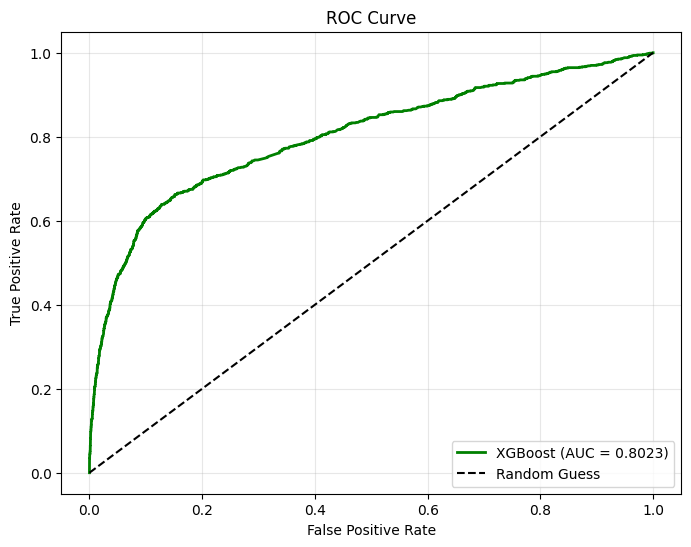

In [31]:
xgb_best = XGBClassifier(
    **random_search.best_params_,
    random_state=17,
    eval_metric='logloss'
)

xgb_best.fit(X_train_processed, y_train)

X_test_processed = preprocessor.transform(X_test)

y_train_pred_proba = xgb_best.predict_proba(X_train_processed)[:, 1]
y_test_pred_proba = xgb_best.predict_proba(X_test_processed)[:, 1]
y_test_pred = xgb_best.predict(X_test_processed)

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Train ROC-AUC: {train_auc:.4f}")
print(f"Test ROC-AUC:  {test_auc:.4f}")

plt.figure(figsize=(8, 6))

fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {test_auc:.4f})', color='green', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# Аналіз важливості ознак та помилок

          Feature  Importance
      nr.employed        0.61
    cons.conf.idx        0.05
is_prev_contacted        0.05
 poutcome_success        0.04
     emp.var.rate        0.04
        month_oct        0.03
      job_retired        0.02
   cons.price.idx        0.01
contact_telephone        0.01
        euribor3m        0.01


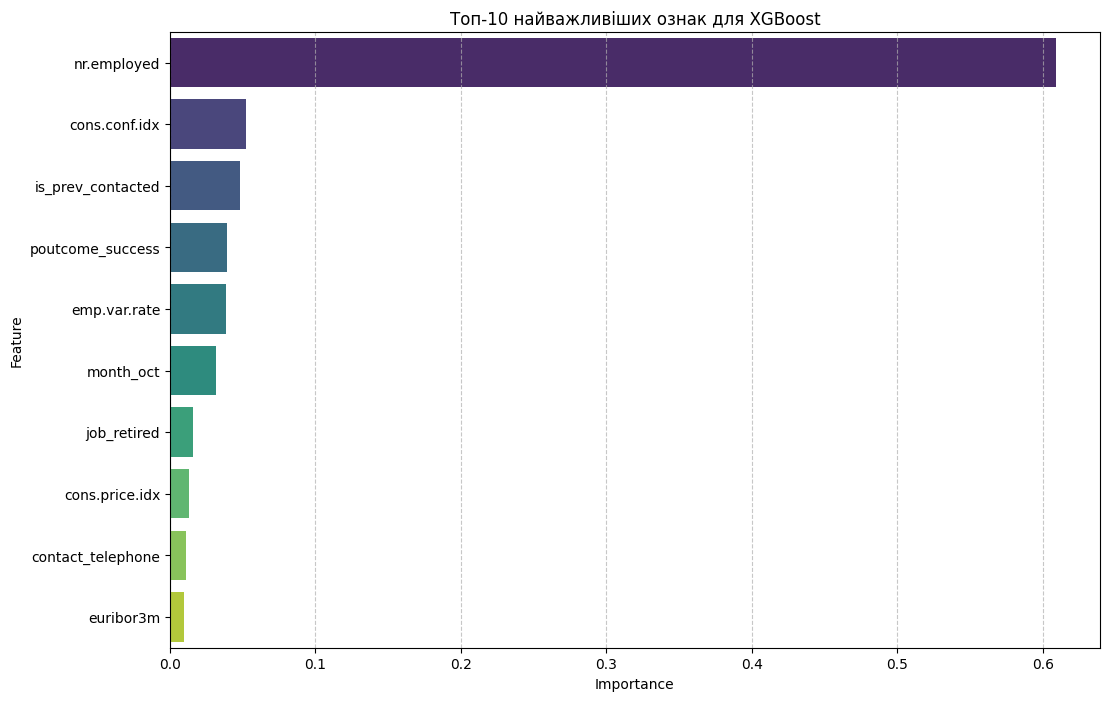

In [32]:
ohe_transformer = preprocessor.named_transformers_['categorical_transform']['onehot']
ohe_feature_names = ohe_transformer.get_feature_names_out(categorical_cols)

feature_names = log_transform_cols + numeric_cols + list(ohe_feature_names)

importances = xgb_best.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_features, x='Importance', y='Feature', hue='Feature', palette='viridis')

print(top_features[['Feature', 'Importance']].head(10).to_string(index=False))

plt.title('Топ-10 найважливіших ознак для XGBoost')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


На мою думку, цей список є доволі адекватним і логічним:

1. Значний вплив мають макроекономічні фактори, але можна окремо виділити саме nr.employed (кількість зайнятих). Коли висока зайнятість, люди мають вільні гроші і готові їх вкладати

2. Поведінка в минулому (poutcome_success, is_prev_contacted)
Якщо клієнт погоджувався на пропозицію минулого разу, то більша ймовірність, що погодиться і цього разу. Також клієнт з якими вже контактували частіше відкривають депозит.

3. Вид зайнятості retired
Пенсіонери (retired) мають накопичення, вони консервативні і вони шукають надійність. Також під час EDA ми бачили, що люди віком 60+ років частіше відкривають депозити.

4. Сезонність (month_oct)
Під час проведення EDA також бачили, що є певна сезонність.

In [33]:
X_test_shap_df = pd.DataFrame(X_test_processed, columns=feature_names)

In [34]:
explainer = shap.Explainer(xgb_best)

shap_values = explainer(X_test_shap_df)

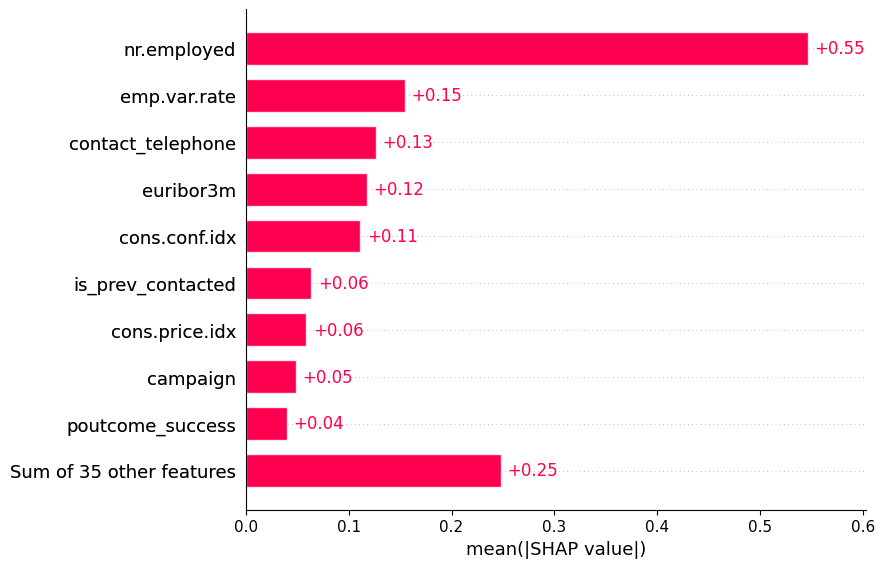

In [35]:
shap.plots.bar(shap_values, max_display=10)

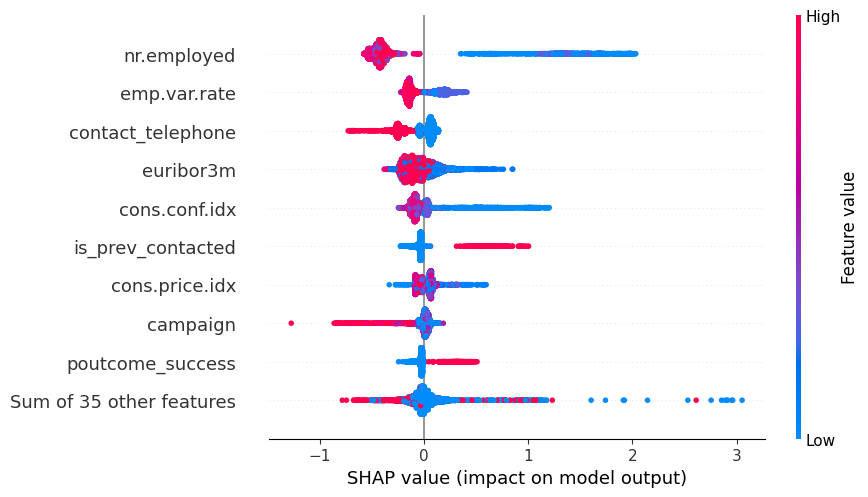

In [36]:
plt.figure(figsize=(12, 10))
shap.plots.beeswarm(shap_values, max_display=10)

Тут також бачимо найбільший вплив макроекономічних факторів. Але цікаво, що низькі значення nr.employed навпаки зменшували прогноз ймовірності відкриття депозиту

Дзвінки на стаціонарні телефони показали вищу ефективність. Це може бути індикатором більш вікової аудиторії, яка традиційно є цільовим сегментом для депозитних продуктів.

Клієнти, з якими банк вже мав контакт у минулому частіше відкривають нові депозити.

In [37]:
y_pred_proba = xgb_best.predict_proba(X_test_processed)[:, 1]
y_pred = xgb_best.predict(X_test_processed)

In [38]:
analysis_df = X_test.copy()
analysis_df['Actual'] = y_test
analysis_df['Predicted'] = y_pred
analysis_df['Probability'] = y_pred_proba

In [39]:
fn_df = analysis_df[(analysis_df['Actual'] == 1) & (analysis_df['Predicted'] == 0)]

fp_df = analysis_df[(analysis_df['Actual'] == 0) & (analysis_df['Predicted'] == 1)]

tp_df = analysis_df[(analysis_df['Actual'] == 1) & (analysis_df['Predicted'] == 1)]

print(f"Кількість False Negatives: {len(fn_df)}")
print(f"Кількість False Positives: {len(fp_df)}")
print("-" * 30)

Кількість False Negatives: 704
Кількість False Positives: 101
------------------------------


In [40]:
metrics_cols = ['euribor3m', 'nr.employed', 'emp.var.rate', 'campaign']

comparison_fn = pd.DataFrame({
    'Missed Clients (FN)': fn_df[metrics_cols].mean(),
    'Caught Clients (TP)': tp_df[metrics_cols].mean(),
    'Diff': fn_df[metrics_cols].mean() - tp_df[metrics_cols].mean()
})
display(comparison_fn.round(3))

print("\nРоль попередніх успіхів (Poutcome)")
print("Відсоток клієнтів з успішною попередньою кампанією:")
poutcome_stats = pd.DataFrame({
    'У групі FN (Пропущені)': [fn_df[fn_df['poutcome'] == 'success'].shape[0] / len(fn_df)],
    'У групі TP (Знайдені)': [tp_df[tp_df['poutcome'] == 'success'].shape[0] / len(tp_df)]
}, index=['% Success History'])
display(poutcome_stats.style.format("{:.1%}"))

,Missed Clients (FN),Caught Clients (TP),Diff
euribor3m,2.44,0.94,1.51
nr.employed,5119.16,5012.81,106.36
emp.var.rate,-1.05,-1.95,0.89
campaign,2.19,1.65,0.54



Роль попередніх успіхів (Poutcome)
Відсоток клієнтів з успішною попередньою кампанією:


,У групі FN (Пропущені),У групі TP (Знайдені)
% Success History,4.1%,75.0%


In [41]:
new_threshold = 0.3
y_pred_new = (y_pred_proba >= new_threshold).astype(int)

print(f"Старий поріг (0.5):")
print(confusion_matrix(y_test, y_pred))
print(f"\nНовий поріг ({new_threshold}):")
cm_new = confusion_matrix(y_test, y_pred_new)
print(cm_new)

new_tp = cm_new[1, 1]
old_tp = confusion_matrix(y_test, y_pred)[1, 1]
added_clients = new_tp - old_tp
added_calls = cm_new[0, 1] - confusion_matrix(y_test, y_pred)[0, 1]

print(f"\nЗнизивши поріг до {new_threshold}, ми знайшли додатково {added_clients} клієнтів.")
print(f"Але для цього доведеться зробити на {added_calls} контактів більше.")

Старий поріг (0.5):
[[7209  101]
 [ 704  224]]

Новий поріг (0.3):
[[6865  445]
 [ 471  457]]

Знизивши поріг до 0.3, ми знайшли додатково 233 клієнтів.
Але для цього доведеться зробити на 344 контактів більше.


Вплив макроекономіки: Основна частина пропущених клієнтів (False Negatives) припадає на більші відсоткові ставки (Euribor ~2.5%), тоді як модель надає перевагу стабільним періодам (Euribor < 1%).

Історія клієнта: Модель схильна занижувати ймовірність успіху для нових клієнтів, покладаючись на наявність успішних угод у минулому.

Якщо вважати, що втрата клієнта для банку важливіша за вартість одного телефонного дзвінка, ми можемо знизити поріг класифікації з 0.5 до 0.3 і тим самим виявити нових 233 клієнтів (+83%), яких модель раніше ігнорувала.

Можна також ще додатково спробувати застосувати методи ресемплингу типу SMOTE, а також натренувати окремі моделі для нових і старих клієнтів.